# pytorch version 이슈로 version downgrade

In [1]:
! pip install torch==1.0.0 torchvision==0.2.1
# pip install "pillow<7"

     |████████████████████████████████| 591.8 MB 621 bytes/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.0.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.0.0 which is incompatible.


# Import Library

In [1]:
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.utils as vutils
import torch
import torchvision
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# visualization 
import matplotlib.pyplot as plt
import cv2

In [2]:
import torch
torch.__version__

'1.0.0'

# Config

In [66]:
batch_size = 100
lr = 1e-4
latent_size = 256
num_epochs = 100
cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'
root = './'
dropout = 0.2

# Load Data

In [5]:
train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=root, train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ])),
        batch_size=batch_size, shuffle=True)

### visualization

In [6]:
data, target = next(iter(train_loader))

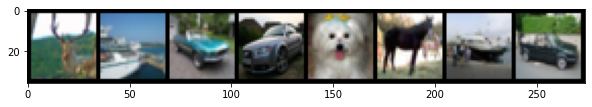

In [7]:
img = torchvision.utils.make_grid(data[0:8])
plt.figure(figsize=(10, 4))
plt.imshow(img.permute(1,2,0))
plt.show()

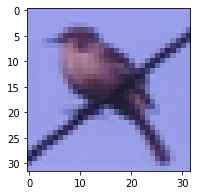

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(data[25].permute(1,2,0))

# Model

### Encoder

In [9]:
class Encoder(nn.Module):

    def __init__(self, latent_size, noise=False):
        super(Encoder, self).__init__()
        self.latent_size = latent_size

        if noise:
            self.latent_size *= 2
          
        self.main1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(32, 64, 4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(64, 128, 4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(128, 256, 4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=False)
        )

        self.main2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=False)
        )

        self.main3 = nn.Sequential(
            nn.Conv2d(512, 512, 1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=False)
        )

        self.main4 = nn.Sequential(
            nn.Conv2d(512, self.latent_size, 1, stride=1, bias=True)
        )

    def forward(self, input):
        batch_size = input.size()[0]
        x1 = self.main1(input)
        x2 = self.main2(x1)
        x3 = self.main3(x2)
        output = self.main4(x3)
        return output, x3.view(batch_size, -1), x2.view(batch_size, -1), x1.view(batch_size, -1)

In [10]:
netE = Encoder(latent_size, noise=True)
z_real, x3, x2, x1 = netE(data)

In [11]:
z_real.shape

torch.Size([100, 512, 1, 1])

In [12]:
z_real = z_real.view(batch_size, -1)
z_real.shape

torch.Size([100, 512])

In [13]:
mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]

In [14]:
mu.shape

torch.Size([100, 256])

In [15]:
log_sigma.shape

torch.Size([100, 256])

In [16]:
epsilon = torch.randn(batch_size, latent_size)
output_z = mu + epsilon * log_sigma
output_z.shape

torch.Size([100, 256])

### Decoder

In [17]:
class Decoder(nn.Module):

    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.latent_size = latent_size

        self.output_bias = nn.Parameter(torch.zeros(3, 32, 32), requires_grad=True)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 256, 4, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(256, 128, 4, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(128, 64, 4, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(64, 32, 4, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(32, 32, 5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(32, 32, 1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=False),

            nn.ConvTranspose2d(32, 3, 1, stride=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.main(input)
        output = output + self.output_bias
        output = self.sigmoid(output)
        return output

In [18]:
z_fake = torch.randn(batch_size, latent_size, 1, 1)

In [19]:
netD = Decoder(latent_size)
output = netD(z_fake)
output.shape

torch.Size([100, 3, 32, 32])

### Discriminator

In [20]:
class Discriminator(nn.Module):

    def __init__(self, latent_size, dropout, output_size=10):
        super(Discriminator, self).__init__()
        self.latent_size = latent_size
        self.dropout = dropout
        self.output_size = output_size

        self.infer_x = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, bias=True),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(32, 64, 4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(64, 128, 4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(128, 256, 4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(256, 512, 4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout)
        )

        self.infer_z = nn.Sequential(
            nn.Conv2d(self.latent_size, 512, 1, stride=1, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(512, 512, 1, stride=1, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout)
        )

        self.infer_joint = nn.Sequential(
            nn.Conv2d(1024, 1024, 1, stride=1, bias=True),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(1024, 1024, 1, stride=1, bias=True),
            nn.LeakyReLU(inplace=False),
            nn.Dropout2d(p=self.dropout)
        )

        self.final = nn.Conv2d(1024, self.output_size, 1, stride=1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, z):
        output_x = self.infer_x(x) # (batch_size, 3, 32, 32) => (batch_size, 512, 1, 1)
        output_z = self.infer_z(z) # (batch_size, latent_size, 1, 1) => (batch_size, 512, 1, 1)
        # ------------ infer_joint & final --------------
        '''
        (batch_size, 1024, 1, 1) => (batch_size, 1, 1, 1) => sigmoid (확률) : Discriminator
        '''
        output_features = self.infer_joint(torch.cat([output_x, output_z], dim=1)) 
        output = self.final(output_features)
        if self.output_size == 1:
            output = self.sigmoid(output)
        # ------------------------------------------------
        return output.squeeze(), output_features.view(x.size()[0], -1)

# Train

### Function

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)

def log_sum_exp(input):
    m, _ = torch.max(input, dim=1, keepdim=True)
    input0 = input - m
    m.squeeze()
    return m + torch.log(torch.sum(torch.exp(input0), dim=1))

def get_log_odds(raw_marginals):
    marginals = torch.clamp(raw_marginals.mean(dim=0), 1e-7, 1 - 1e-7)
    return torch.log(marginals / (1 - marginals))

In [22]:
# encoder, decoder, discriminator
E = Encoder(latent_size, True).to(cuda_device)
D = Decoder(latent_size).to(cuda_device)
Dis = Discriminator(latent_size, 0.2, 1).to(cuda_device)

E.apply(weights_init)
D.apply(weights_init)
Dis.apply(weights_init)

Discriminator(
  (infer_x): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout2d(p=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout2d(p=0.2)
    (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Dropout2d(p=0.2)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout2d(p=0.2)
    (15): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (16): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

In [23]:
# optimizer
optimizerG = optim.Adam([{'params' : E.parameters()},
                         {'params' : D.parameters()}], lr=lr, betas=(0.5,0.999))

optimizerD = optim.Adam(Dis.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [24]:
def train():
    
    d_loss_lst = []
    g_loss_lst = []

    for epoch in range(num_epochs):

        i = 0
        for (data, target) in train_loader:

            real_label = torch.ones(batch_size).to(cuda_device)
            fake_label = torch.zeros(batch_size).to(cuda_device)

            noise1 = torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(cuda_device)
            noise2 = torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(cuda_device)

            if epoch == 0 and i == 0:
                D.output_bias.data = get_log_odds(data.to(cuda_device))

            if data.size()[0] != batch_size:
                continue

            d_real = data.to(cuda_device)

            z_fake = torch.randn(batch_size, latent_size, 1, 1).to(cuda_device)
            d_fake = D(z_fake)

            z_real, _, _, _ = E(d_real)
            z_real = z_real.view(batch_size, -1)

            mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]
            sigma = torch.exp(log_sigma)
            epsilon = torch.randn(batch_size, latent_size).to(cuda_device)

            output_z = mu + epsilon * sigma

            output_real, _ = Dis(d_real + noise1, output_z.view(batch_size, latent_size, 1, 1))
            output_fake, _ = Dis(d_fake + noise2, z_fake)

            loss_d = criterion(output_real, real_label) + criterion(output_fake, fake_label)
            loss_g = criterion(output_fake, real_label) + criterion(output_real, fake_label)

            #-- generator loss가 3.5를 넘지 않을 때까지 discriminator만 학습. 
            if loss_g.item() < 3.5:
                optimizerD.zero_grad()
                loss_d.backward(retain_graph=True)
                optimizerD.step()

            #-- generator 학습 
            optimizerG.zero_grad()
            loss_g.backward()
            optimizerG.step()

            #-- 50 iteration마다 discriminator(x_real, z_real), discriminator(x_fake, z_fake) 확률 print 
            #-- 50 iteration마다 discriminator loss, generator loss print 
            #-- 50 iteration마다 실제 이미지, ALI 생성 이미지 저장 
            if i % 200 == 0:
                print("Epoch :", epoch, "Iter :", i, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                      "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())

            if i % 50 == 0:
                vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake.png' % (root))
                vutils.save_image(d_real.cpu().data[:16, ], './%s/real.png'% (root))

            i += 1

        #-- epoch마다 discriminator loss, generator loss 저장 
        d_loss_lst.append(loss_d.item())
        g_loss_lst.append(loss_g.item())  

        #-- 10 epoch마다 discriminator, decoder, encoder 저장 / ALI생성 이미지 저장 
        if epoch % 10 == 0:
            torch.save(D.state_dict(), './%s/netD_epoch_%d.pth' % (root, epoch))
            torch.save(E.state_dict(), './%s/netE_epoch_%d.pth' % (root, epoch))
            torch.save(Dis.state_dict(), './%s/netDis_epoch_%d.pth' % (root, epoch))

            vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake_%d.png' % (root, epoch))

    return d_loss_lst, g_loss_lst    

In [25]:
cuda_device

'cuda'

In [67]:
d_loss_lst, g_loss_lst = train()

Epoch : 0 Iter : 0 D Loss : 1.7899150848388672 G loss : 2.1843550205230713 D(x) : 0.27894747257232666 D(G(x)) : 0.2197185456752777
Epoch : 0 Iter : 200 D Loss : 1.3802719116210938 G loss : 1.9513047933578491 D(x) : 0.45642614364624023 D(G(x)) : 0.3481486439704895
Epoch : 0 Iter : 400 D Loss : 1.0631237030029297 G loss : 2.5252904891967773 D(x) : 0.675684928894043 D(G(x)) : 0.39903467893600464
Epoch : 1 Iter : 0 D Loss : 1.1886913776397705 G loss : 2.230092763900757 D(x) : 0.5299792885780334 D(G(x)) : 0.329045832157135
Epoch : 1 Iter : 200 D Loss : 0.8219882845878601 G loss : 2.851954460144043 D(x) : 0.6313525438308716 D(G(x)) : 0.24774959683418274
Epoch : 1 Iter : 400 D Loss : 1.2698907852172852 G loss : 2.0859808921813965 D(x) : 0.5756641626358032 D(G(x)) : 0.41120147705078125
Epoch : 2 Iter : 0 D Loss : 1.0068546533584595 G loss : 2.5484776496887207 D(x) : 0.6425414681434631 D(G(x)) : 0.3453747630119324
Epoch : 2 Iter : 200 D Loss : 0.7319211959838867 G loss : 3.0540199279785156 D(x)

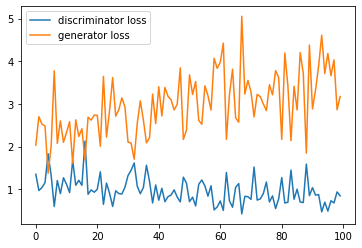

In [68]:
plt.plot(range(len(d_loss_lst)), d_loss_lst, label='discriminator loss')
plt.plot(range(len(g_loss_lst)), g_loss_lst, label='generator loss')
plt.legend()
plt.show()

# Generated images 

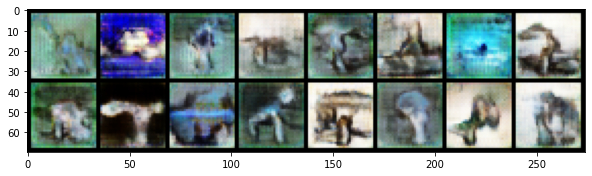

In [69]:
# epoch 1
img = cv2.imread('./fake_0.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

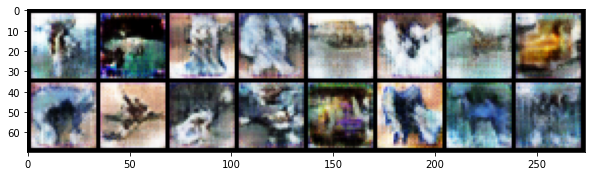

In [70]:
# epoch 10
img = cv2.imread('./fake_10.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

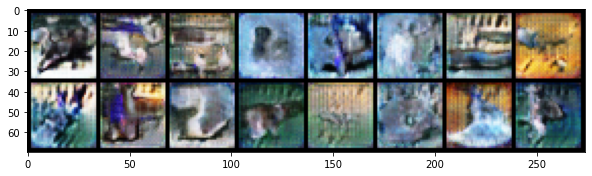

In [71]:
# epoch 20
img = cv2.imread('./fake_20.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

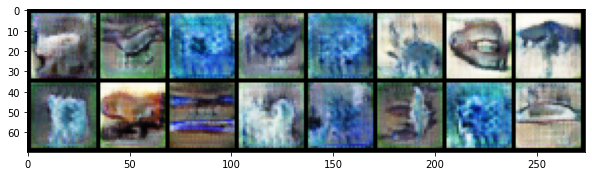

In [72]:
# epoch 30
img = cv2.imread('./fake_30.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

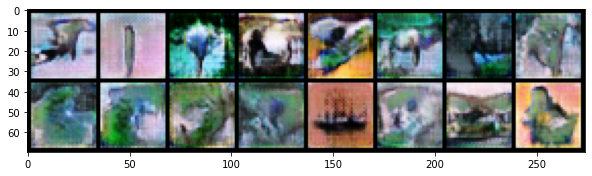

In [73]:
# epoch 40
img = cv2.imread('./fake_40.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

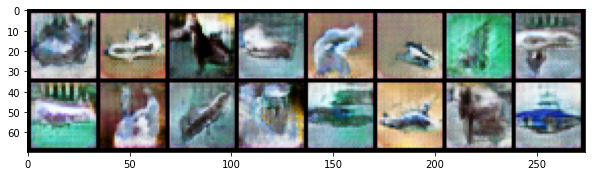

In [74]:
# epoch 50
img = cv2.imread('./fake_50.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

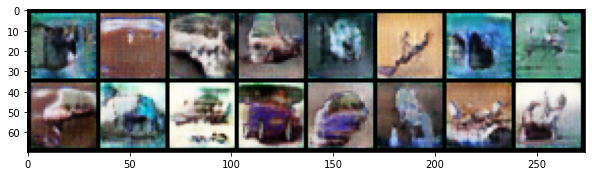

In [75]:
# epoch 70
img = cv2.imread('./fake_70.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

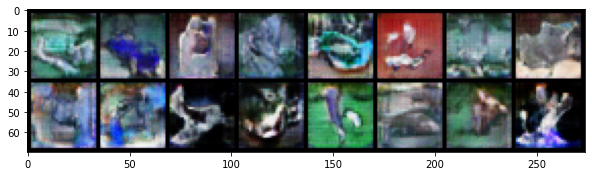

In [76]:
# epoch 90
img = cv2.imread('./fake_90.png')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

# Inference 

In [77]:
# Load Model (trained)

encoder = Encoder(latent_size, True)
encoder.load_state_dict(torch.load('./netE_epoch_50.pth'))
encoder.eval()

decoder = Decoder(latent_size)
decoder.load_state_dict(torch.load('./netD_epoch_50.pth'))
decoder.eval()

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (13): BatchNorm2d(32, eps=1e-05, moment

### x -> encoder -> latent representation -> decoder -> x_2
- x와 x_2 비교 

In [78]:
# sample data 생성 (real data)
data, _ = next(iter(train_loader))
data.shape

torch.Size([100, 3, 32, 32])

In [79]:
x = data[i]
x.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [80]:
# batch size 100에서 랜덤하게 하나 뽑기 
i = np.random.randint(100) 
x = data[i]

# Encoder
E.eval()
z_real, _, _, _ = E(x.unsqueeze(0).to(cuda_device)) 
z_real = z_real.view(1, -1)

# Encoder output => latent z 
mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]
sigma = torch.exp(log_sigma)
epsilon = torch.randn(1, latent_size).to(cuda_device)

output_z = mu + epsilon * sigma # => latent representation of image

# Decoder
x_2 = D(output_z.view(-1, latent_size, 1, 1).to(cuda_device))

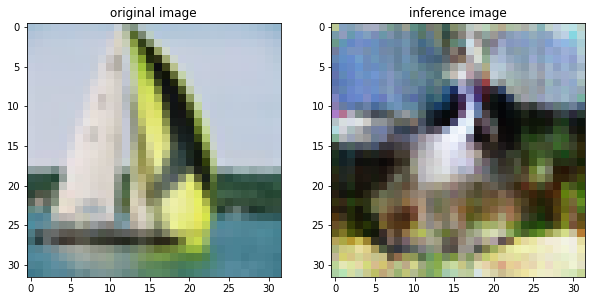

In [81]:
fig = plt.figure(figsize=(10,8))

row=1
cols=2 

ax1 = fig.add_subplot(row, cols, 1)
ax1.imshow(x.permute(1,2,0))
ax1.set_title('original image')

ax2 = fig.add_subplot(row, cols, 2)
ax2.imshow(x_2[0].cpu().detach().permute(1,2,0))
ax2.set_title('inference image')

plt.show()

### z => random noise => z2
- z와 z2를 모두 decoder에 넣고 유사한지 비교해보기

In [82]:
# 임의의 z 생성 
z = torch.randn(1, latent_size, 1, 1).to(cuda_device)
# z에 noise 추가한 z2생성
noise = torch.Tensor(z.size()).normal_(0, 0.2).to(cuda_device)
z2 = z + noise

In [83]:
# Decoder
x_1 = D(z)
x_2 = D(z2)

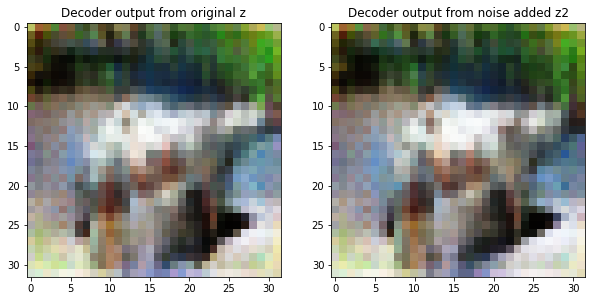

In [84]:
fig = plt.figure(figsize=(10,8))

row=1
cols=2 

ax1 = fig.add_subplot(row, cols, 1)
ax1.imshow(x_1[0].cpu().detach().permute(1,2,0))
ax1.set_title('Decoder output from original z')

ax2 = fig.add_subplot(row, cols, 2)
ax2.imshow(x_2[0].cpu().detach().permute(1,2,0))
ax2.set_title('Decoder output from noise added z2')

plt.show()

### x1 => encoder => z1
### x2 => encoder => z2 
- z1, z2 사이의 z_m으로 이미지 생성

In [85]:
# batch size 100에서 랜덤하게 하나 뽑기 
i = np.random.randint(100) 
j = np.random.randint(100)

print(i, j)

99 91


In [86]:
x1 = data[i]

# Encoder 
z1, _, _, _ = E(x1.unsqueeze(0).to(cuda_device)) 
z1 = z1.view(1, -1)

# Encoder output => latent z 
mu, log_sigma = z1[:, :latent_size], z1[:, latent_size:]
sigma = torch.exp(log_sigma)
epsilon = torch.randn(1, latent_size).to(cuda_device)

output_z1 = mu + epsilon * sigma # => latent representation of image

In [87]:
x2 = data[j]

# Encoder 
z2, _, _, _ = E(x2.unsqueeze(0).to(cuda_device)) 
z2 = z2.view(1, -1)

# Encoder output => latent z 
mu, log_sigma = z2[:, :latent_size], z2[:, latent_size:]
sigma = torch.exp(log_sigma)
epsilon = torch.randn(1, latent_size).to(cuda_device)

output_z2 = mu + epsilon * sigma # => latent representation of image


In [88]:
alpha_lst = np.arange(0, 1.1, 0.1)
print(alpha_lst)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


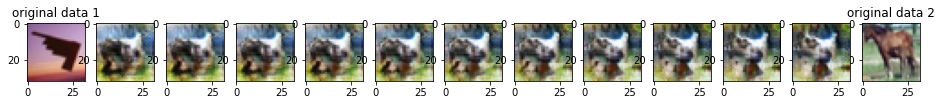

In [89]:
row = 1
cols = 13
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(row, cols, 1)
ax1.imshow(x1.permute(1,2,0))
ax1.set_title('original data 1')

ax13 = fig.add_subplot(row, cols, 13)
ax13.imshow(x2.cpu().permute(1,2,0))
ax13.set_title('original data 2')

for i in range(len(alpha_lst)):
    ax = fig.add_subplot(row, cols, i+2)
    
    alpha = alpha_lst[i]

    tmp_z = alpha * output_z2 + (1-alpha) * output_z1
    tmp_x = D(tmp_z.view(-1, latent_size, 1, 1))
    
    ax.imshow(tmp_x[0].cpu().detach().permute(1,2,0))

plt.show()